In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso, BayesianRidge
from sklearn.neighbors import KNeighborsRegressor

In [2]:
df = pd.read_csv("C:/Users/chole/Desktop/Personal_medical_cost/insurance.csv")
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
X = df.drop(columns=["charges"])
y = df.charges

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42,
                                                    stratify=X[["smoker"]])

In [5]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1070, 6) (268, 6) (1070,) (268,)


In [6]:
column_t = make_column_transformer(
    (OneHotEncoder(drop="if_binary"), ["sex", "region", "smoker"]),
    (StandardScaler(), ["age", "bmi", "children"]),
    remainder="passthrough"
)

LR: 0.725405 (0.061729)
Lasso: 0.725407 (0.061713)
KNN: 0.629534 (0.075079)
Bayesian: 0.725428 (0.061522)


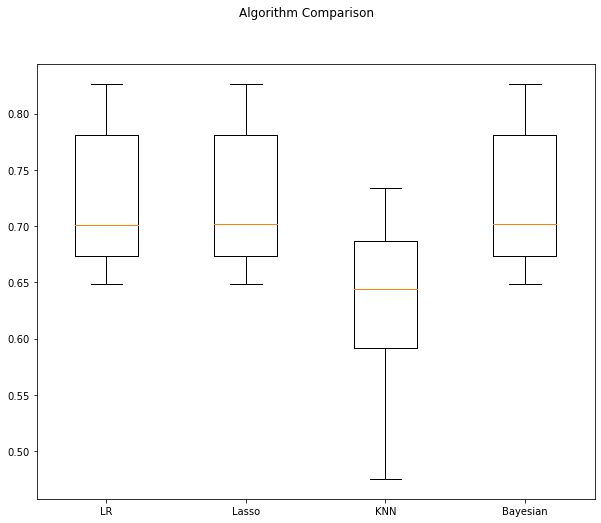

In [22]:
names=[]
results =[] # for all results
score_fp = [] # for mean of r2

models={'LR': LinearRegression(),
       'Lasso': Lasso(),
       'KNN': KNeighborsRegressor(),
       'Bayesian': BayesianRidge()

}

for name, model in models.items(): # need .items() cause dictionary above

    pipe = Pipeline([
        ("preProc", column_t),
        ("model", model)
    ]) # pipeline with preprocessing of the data and model

    cv_res = cross_val_score(pipe, X_train, y_train, cv=10, scoring='r2') # cross-validation    

    results.append(cv_res) # add results to the list
    names.append(name) # add name of algorithm to the list
    score_fp.append(cv_res.mean()) # add mean of r2 to the list
    msg = "%s: %f (%f)" % (name, cv_res.mean(), cv_res.std()) # print nice list with mean and std
    print(msg)

# boxplot algorithm comparison 
# Source: https://machinelearningmastery.com/compare-machine-learning-algorithms-python-scikit-learn/
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111) # all on the same box
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [26]:
dane = {
    "Names": names,
    "Score R^2": score_fp
}

res = pd.DataFrame(dane)  
res

,Names,Score R^2
0,LR,0.725405
1,Lasso,0.725407
2,KNN,0.629534
3,Bayesian,0.725428


In [25]:
res.max()

Names           Lasso
Score R^2    0.725428
dtype: object